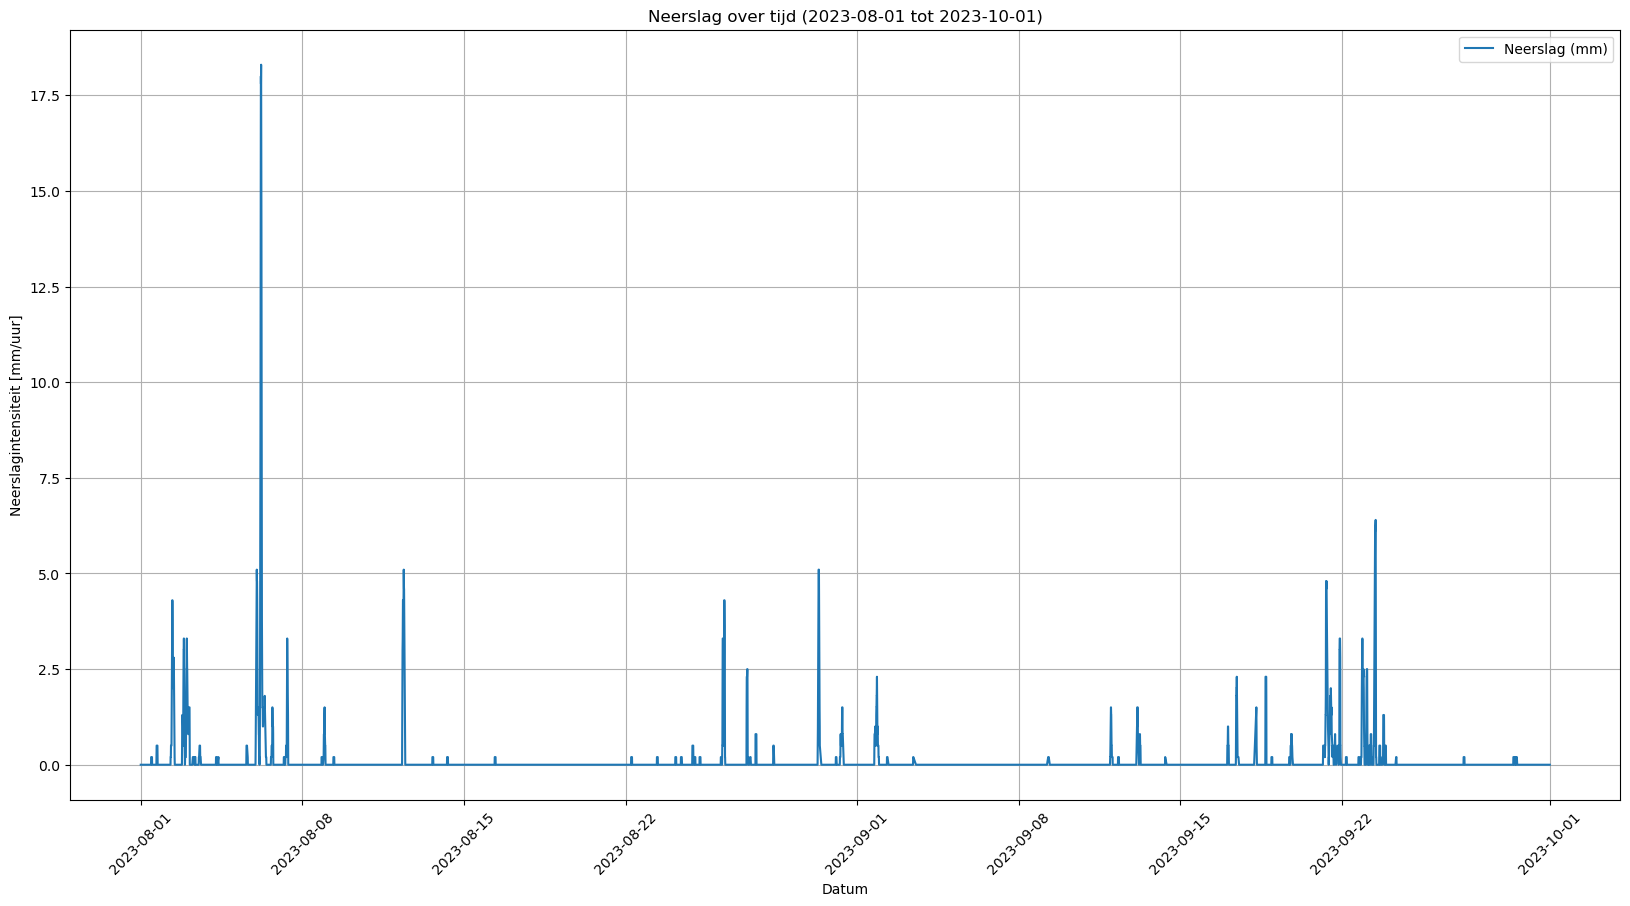

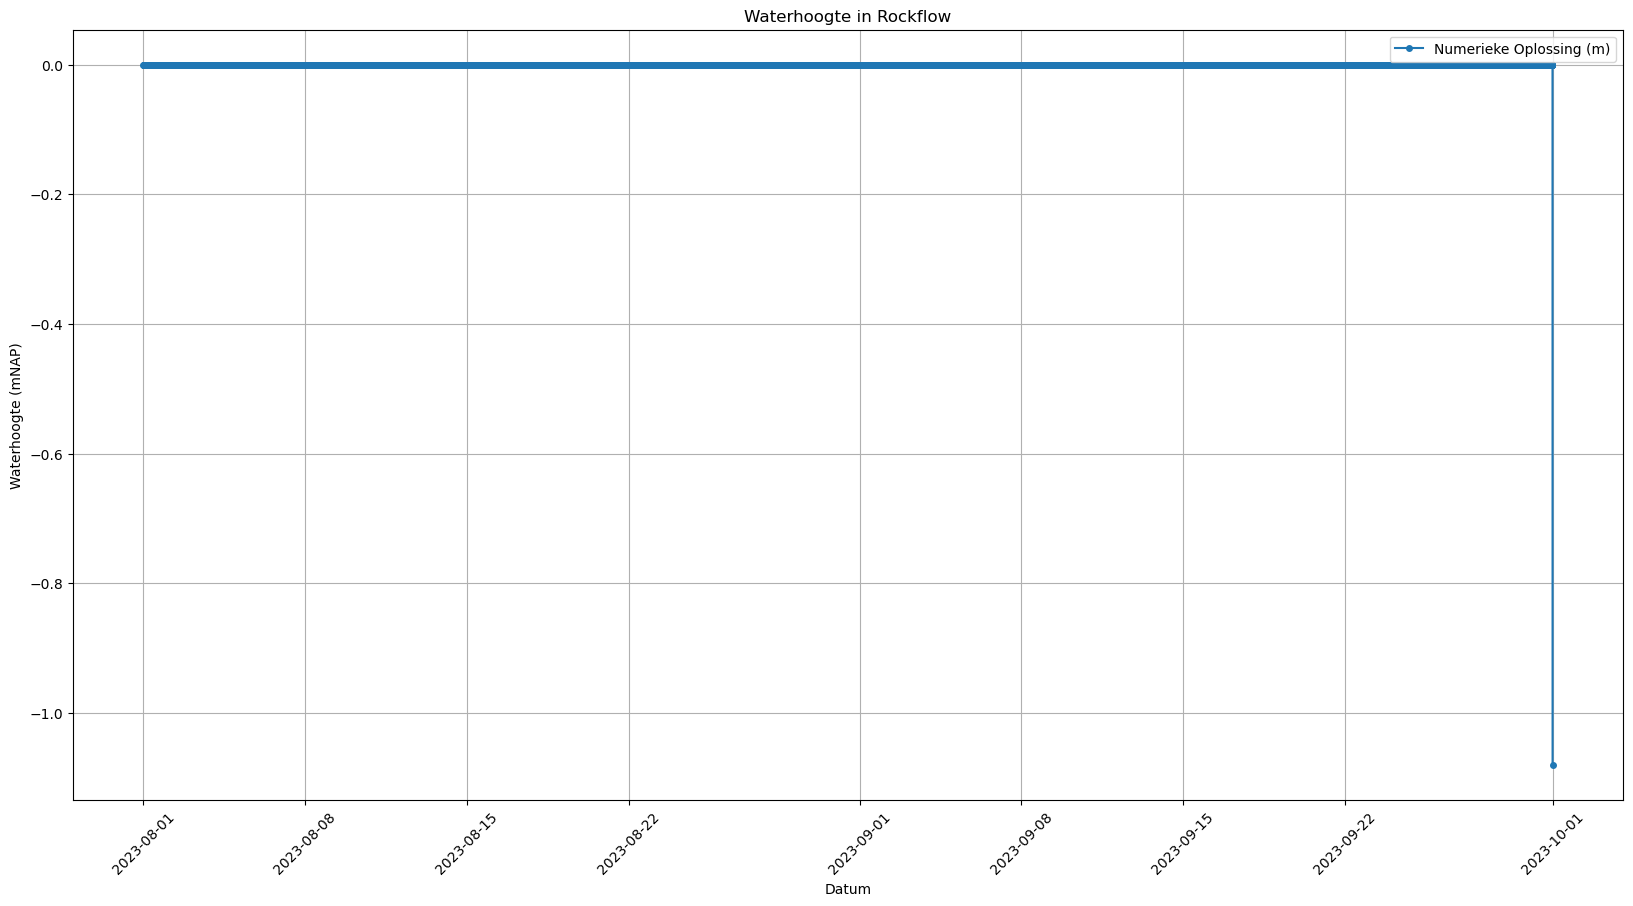

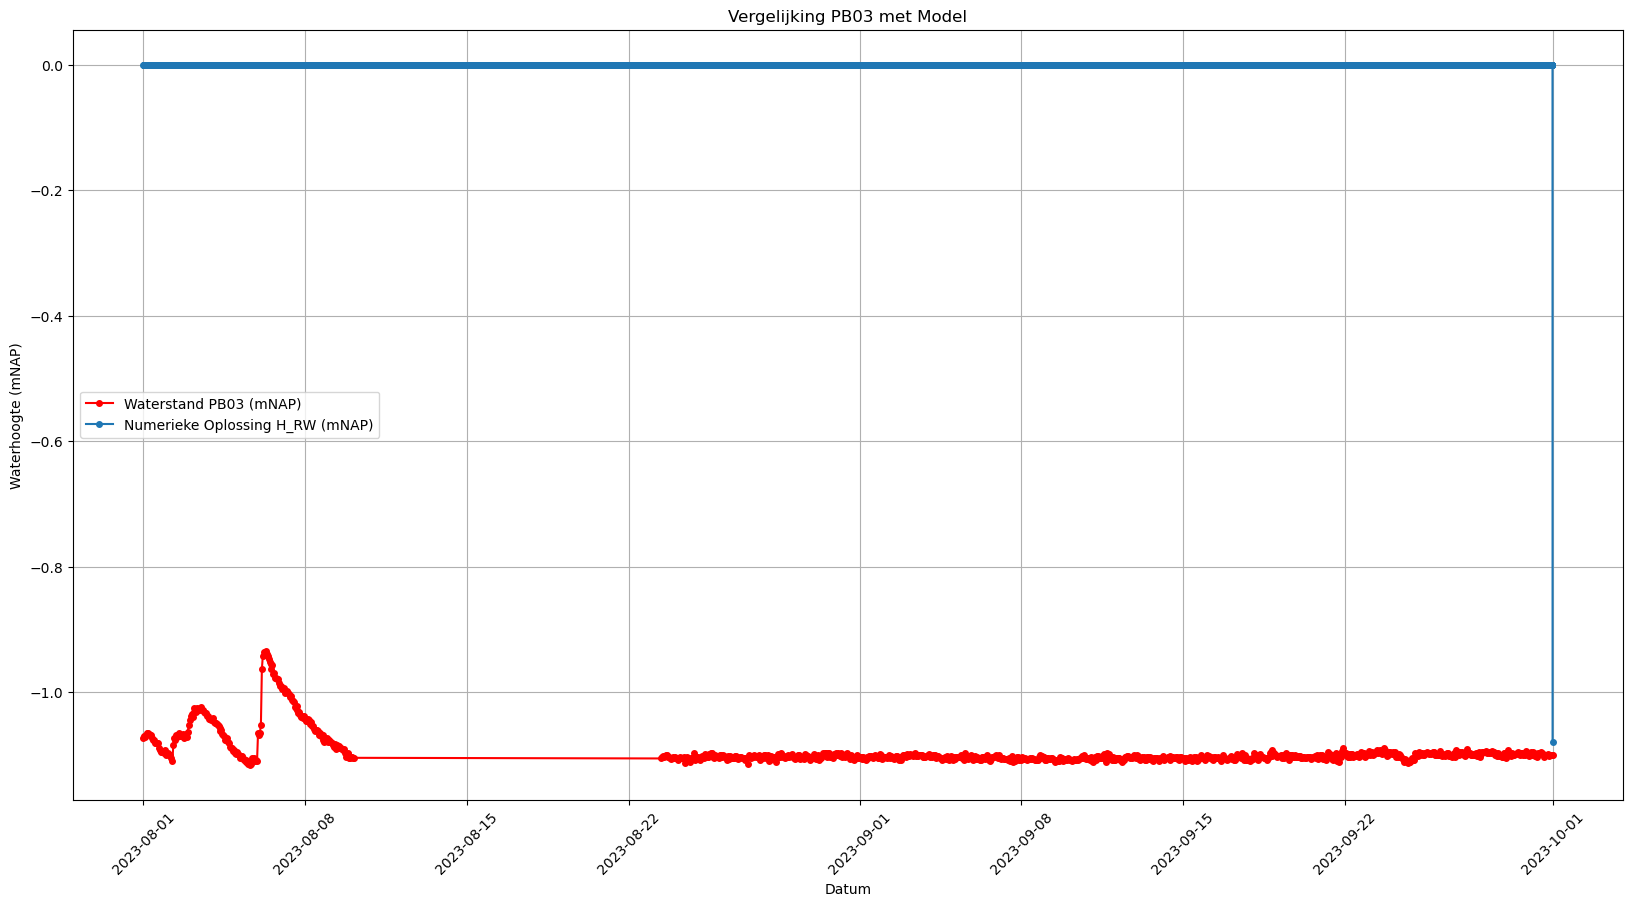

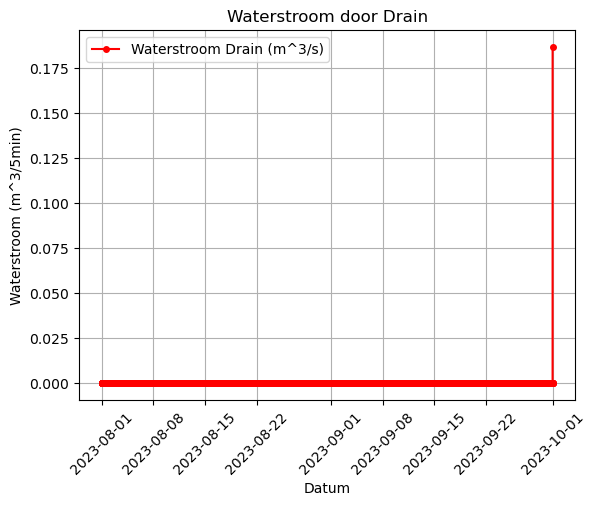

In [19]:
# Lijstje van de benodigde imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math

# Omzetten verkregen dataset KNMI naar lijst met gefilterde waardes

# Inladen neerslagdata
df_neerslag = pd.read_csv('Neerslag_Hoogmade.csv', skipinitialspace=True, header=0, sep=';')

# Maak een datum kolom
df_neerslag['DateTime'] = pd.to_datetime(df_neerslag['datum'])  # format is voor notatie van de import

# Zet 'neerslagintensiteit (mm/uur)' om naar numerieke waarden
df_neerslag['neerslagintensiteit (mm/uur)'] = pd.to_numeric(df_neerslag['neerslagintensiteit (mm/uur)'], errors='coerce')

# Vervang NaN door 0
df_neerslag['neerslagintensiteit (mm/uur)'].fillna(0, inplace=True)

# Datumfilter instellen van 2021-09-01 tot 2021-12-01
start_date = '2023-08-01'
end_date = '2023-10-01'

# Selecteer de rijen binnen het gewenste datum bereik
df_filtered = df_neerslag[(df_neerslag['DateTime'] >= start_date) & (df_neerslag['DateTime'] <= end_date)]

# Plot de DateTime tegenover de RH voor het gefilterde bereik
plt.figure(figsize=(20, 10))
plt.plot(df_filtered["DateTime"], df_filtered["neerslagintensiteit (mm/uur)"], label="Neerslag (mm)")
plt.title("Neerslag over tijd ({} tot {})".format(start_date, end_date))
plt.xlabel("Datum")
plt.ylabel("Neerslagintensiteit [mm/uur]")
plt.grid(True)
plt.xticks(rotation=45)  # Draai datums voor betere leesbaarheid
plt.legend()
plt.show()

# Schakel de waarschuwing uit
pd.set_option('mode.chained_assignment', None)

# Omzetten neerslag naar mm, daarna naar m, door 12 om van mm/uur naar mm/5 min te gaan
df_filtered['neerslagintensiteit (mm/uur)'] = df_filtered['neerslagintensiteit (mm/uur)'] / 1000 / 12

# Zet de waarschuwing weer aan
pd.set_option('mode.chained_assignment', 'warn')

# Haal alle waarden van 'neerslagintensiteit (mm/uur)' op als lijst
neerslag_lijst = df_filtered['neerslagintensiteit (mm/uur)'].tolist()

# Parameters
#Bergend Opp
A_hellend_dak = 660.88
A_vlak_dak = 56.12
A_rijweg_goot = 836.99
A_trottoir_goot = 532.36
A_parkeerplaatsen = 570.08
A_afstromend = A_hellend_dak + A_vlak_dak + A_rijweg_goot + A_trottoir_goot + A_parkeerplaatsen

#Rockflow
A_RF = 1337.53   #Oppervlak van het bergend pakket (m^2)
k_RF = 200/24/12 #Doorlatendheidscoëfficiënt van de rockflow (m/5min)
p_RF = 0.95      #Porositeit Rockwool
Onderkant_RF = -1.08  #In mNAP

#Drainzand
A_DZ = 0.70*180 
k_DZ = 10/24/12
p_DZ = 0.25
B_DZ = 0.30 # Breedte onderkant drainzand
L_DZ = 180 #Lengte onderkant drainzand (evenals de weg)
VMAX_DZ = 0.3348 * L_DZ * p_DZ
Onderkant_DZ = -1.70 #IN mNAP, correctie van 5cm door rechttrekken lijn voor gemiddelde tussen -1,65 en -1,75 mNAP

#Klei
A_KL = 100
k_KL = 0.05/24/12   #Doorlatendheidscoëfficiënt van de bodem (m/5min)
p_KL = 0.4

#Drain
Diameter_DR = 0.1 #M
k_DR = 1.0
A_DR = (math.pi/4)*Diameter_DR**2
#dh = #wordt in formule gezet
dl = 50

#Tijdstappen
t0 = 0
tijdstappen = len(neerslag_lijst)

#Arrays
dt = 1  # Tijdstap (5 minuten)
t = np.arange(0, tijdstappen, dt)  # Tijdstappen
V_RF = np.zeros(len(t))  # Array voor het volume water in de rockwool
H_RF = np.zeros(len(t))  # Array voor de waterhoogte in de rockwool
V_DZ = np.zeros(len(t))  # Array voor het volume water in het drainzand
H_DZ = np.zeros(len(t))  # Array voor de waterhoogte in het drainzand

Q_DR = np.zeros(len(t))  #Array  voor volumestroom door drain
# Q_KL= np.zeros(len(t)) #Array voor volumestroom in klei

# Initiële conditie
V_RF[0] = 0.0  # Initiële volume water in het rockwool(m^3)
V_DZ[0] = 0.0  # Initiële wolume water in het drainzand (m^3)

i = 1

# Numerieke oplossing met behulp van de methode van Euler
for i in range(1, len(t)):
    Q_in_RF = neerslag_lijst[i] * A_afstromend 
    Q_uit_RF = min(V_RF[i-1], A_DZ * k_DZ, VMAX_DZ - V_DZ[i-1])
    Q_DZ_KL = ((L_DZ * 2 * ((H_DZ[i-1] -(Onderkant_DZ))/ math.cos(math.radians(25)))+ (L_DZ * B_DZ)) * k_KL)

    if H_RF[i-1] >= -1.08:
        Q_uit_DR = 0.06 + Q_DZ_KL
    else:
        Q_uit_DR = 0.0 + Q_DZ_KL
    
Q_in_DZ = min(V_RF[i-1], A_DZ * k_DZ, VMAX_DZ - V_DZ[i-1])
Q_uit_DZ = min(V_DZ[i-1], Q_uit_DR) #plaatsen van Kleiinfiltratie uitvoer


V_RF[i] = (Q_in_RF - Q_uit_RF) * dt + V_RF[i-1]
H_RF[i] = V_RF[i] / (p_RF * A_RF) + Onderkant_RF
V_DZ[i] = (Q_in_DZ - Q_uit_DZ) * dt + V_DZ[i-1]
H_DZ[i] = V_DZ[i] / (p_DZ * A_DZ) + Onderkant_DZ
Q_DR[i] = Q_DR[i - 1] + Q_uit_DR

# Plot de numerieke oplossing voor waterhoogte in de RW met datums op de x-as
plt.figure(figsize=(20, 10))
plt.plot(df_filtered['DateTime'], H_RF, label='Numerieke Oplossing (m)', marker='o', markersize=4, linestyle='-')
plt.xlabel('Datum')
plt.ylabel('Waterhoogte (mNAP)')
plt.title('Waterhoogte in Rockflow')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Draai datums voor betere leesbaarheid
plt.show()

# Lees CSV-bestand in met puntkomma als scheidingsteken (PB03)
df_PB03 = pd.read_csv('PB03_01122020_01122023.csv', skipinitialspace=True, header=0, sep=';')

# Maak een datum kolom
df_PB03['DateTime'] = pd.to_datetime(df_PB03['result_timestamp'], format='%d-%m-%Y %H:%M')

# Filter het DataFrame op het gewenste tijdsinterval 
df_filtered_pb03 = df_PB03[(df_PB03['DateTime'] >= start_date) & (df_PB03['DateTime'] <= end_date)]

# Plot de DateTime tegenover het water_level voor PB03
plt.figure(figsize=(20, 10))
plt.plot(df_filtered_pb03["DateTime"], df_filtered_pb03["water_level"], label="Waterstand PB03 (mNAP)", color='red', marker='o', markersize=4, linestyle='-')

# Plot de numerieke oplossing voor waterhoogte in de RW op dezelfde grafiek
plt.plot(df_filtered['DateTime'], H_RF, label='Numerieke Oplossing H_RW (mNAP)', marker='o', markersize=4, linestyle='-')

plt.xlabel('Datum')
plt.ylabel('Waterhoogte (mNAP)')
plt.title('Vergelijking PB03 met Model')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Draai datums voor betere leesbaarheid
plt.show()

# Plot de waterstroom door de drain
plt.plot(df_filtered['DateTime'], Q_DR, label='Waterstroom Drain (m^3/s)', marker='o', markersize=4, linestyle='-', color='red')

plt.xlabel('Datum')
plt.ylabel('Waterstroom (m^3/5min)')
plt.title('Waterstroom door Drain')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Draai datums voor betere leesbaarheid
plt.show()

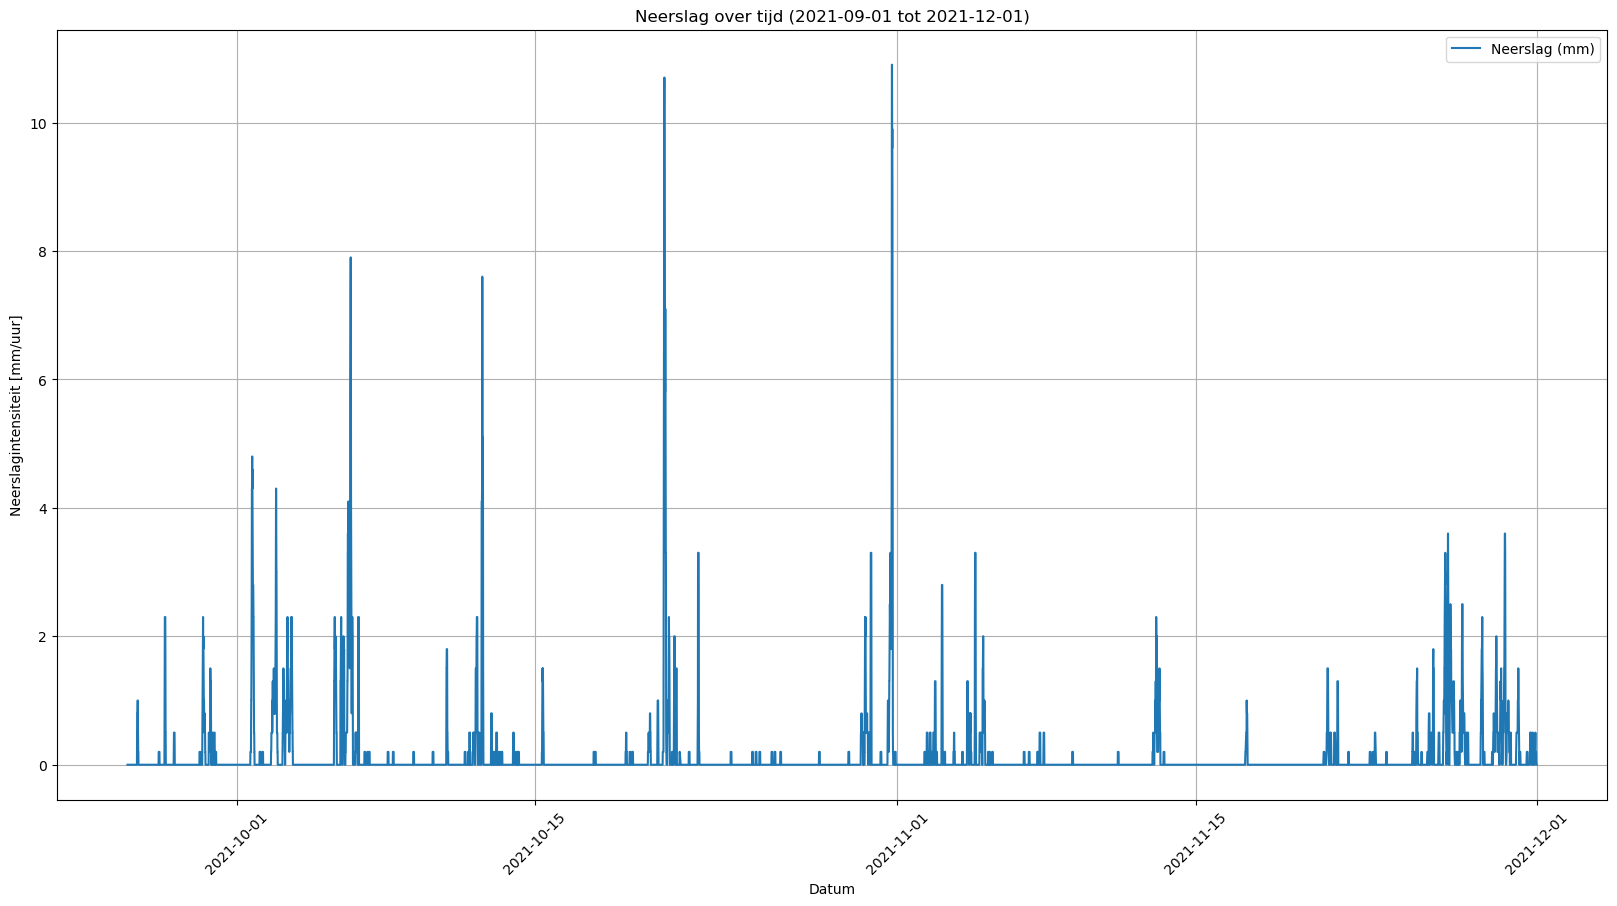

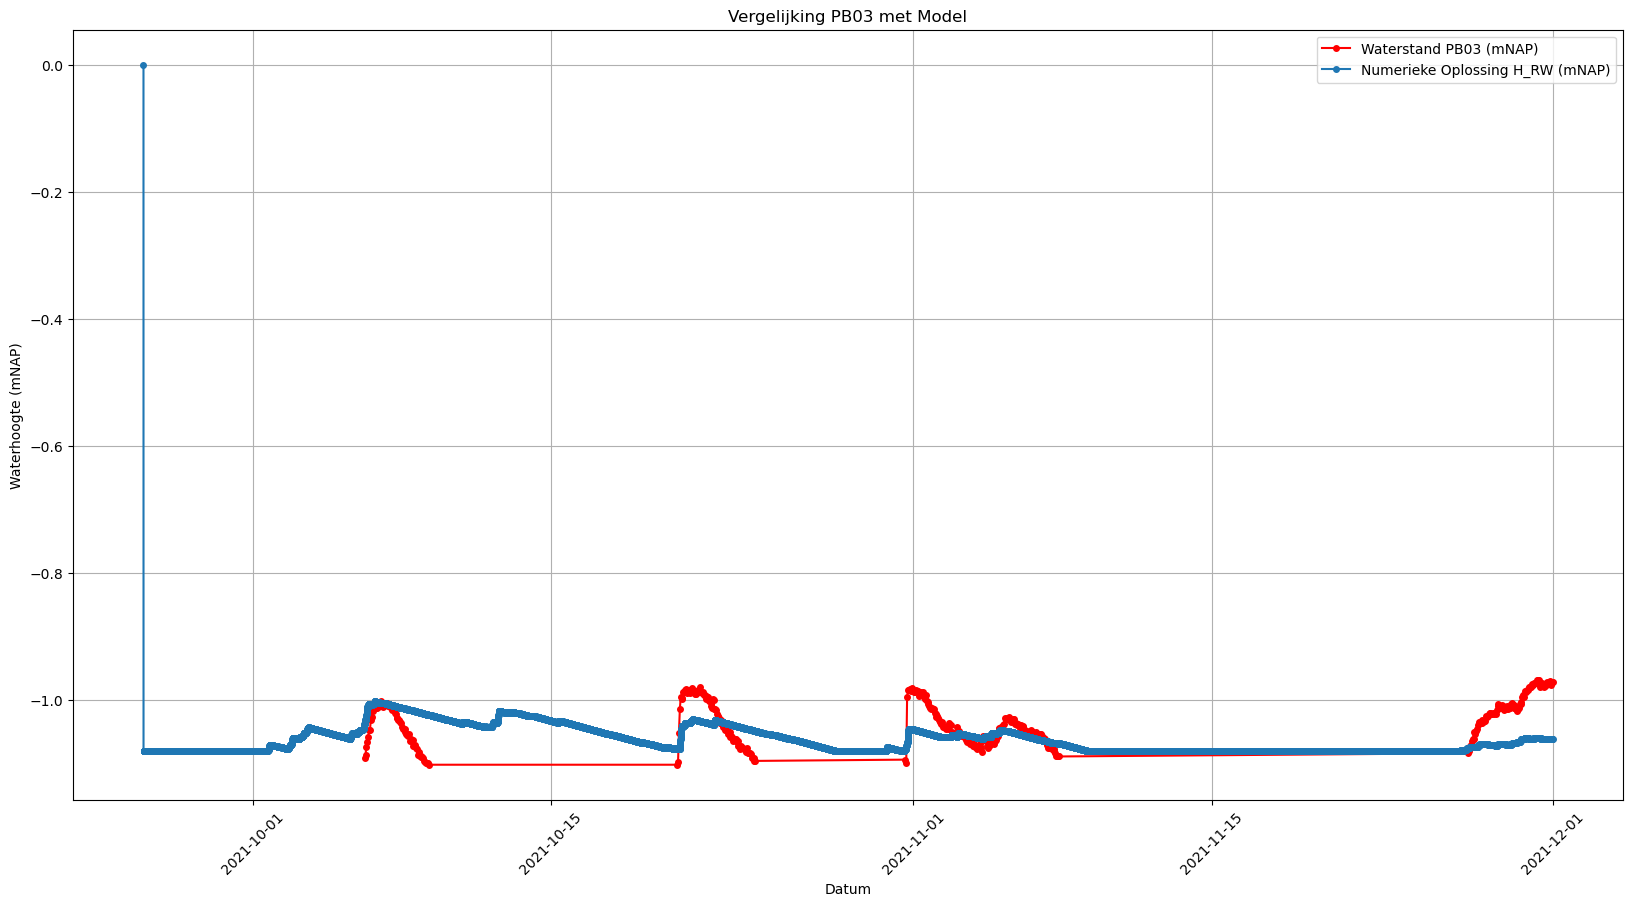

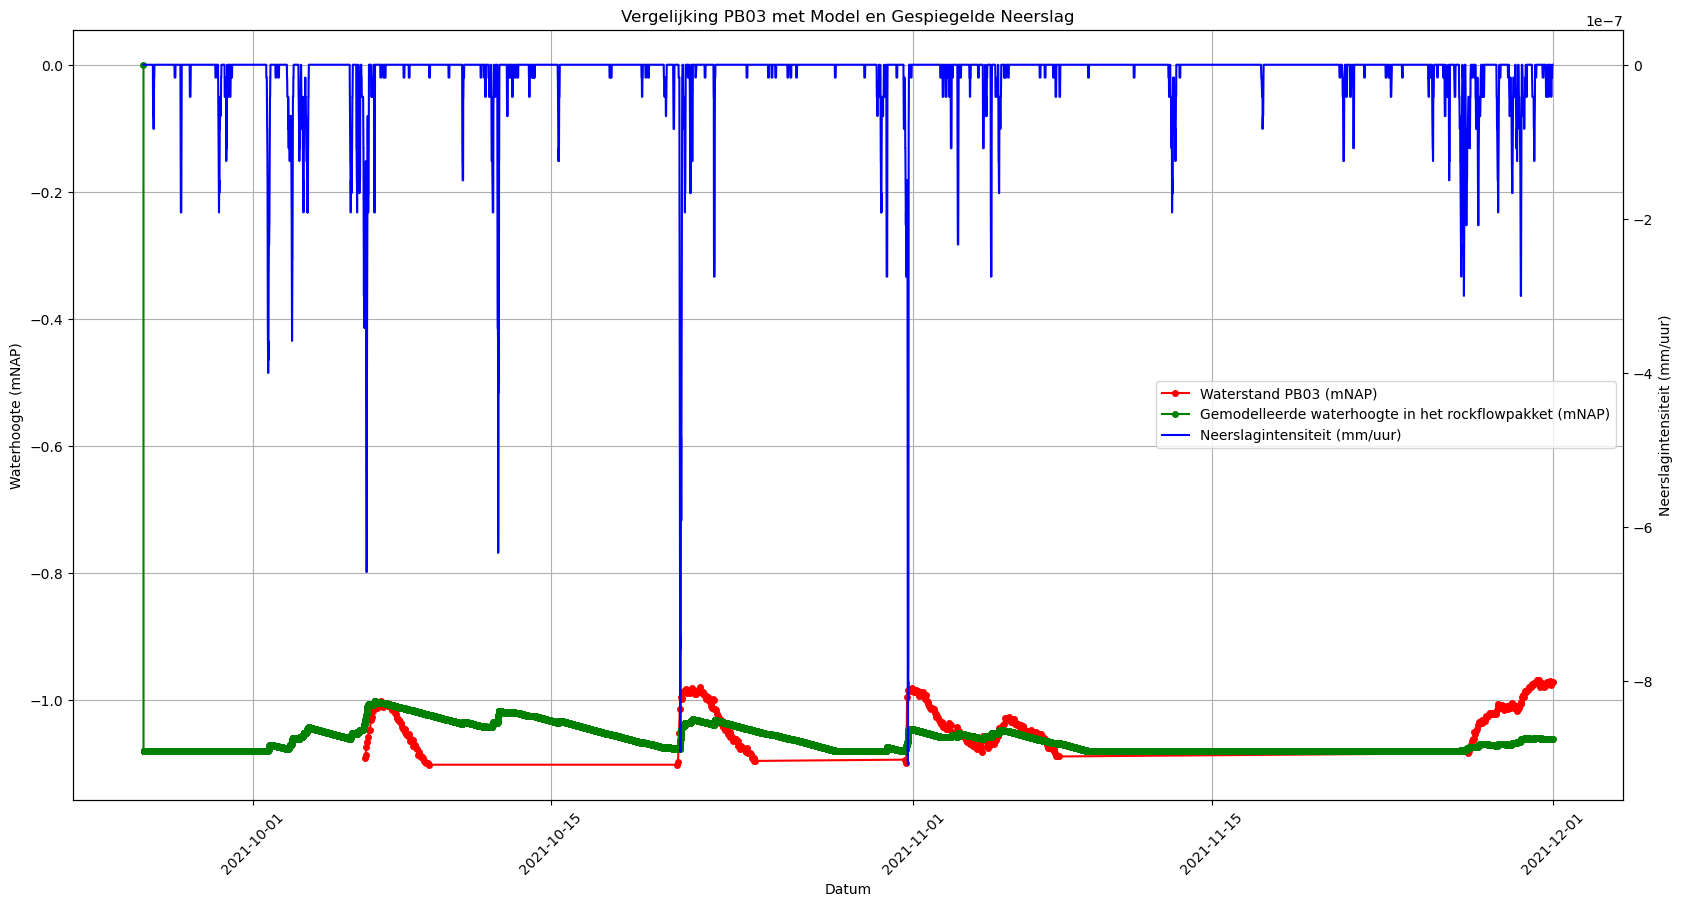

In [2]:
# Lijstje van de benodigde imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math

# Datumfilter instellen
start_datum = '2021-09-01'
eind_datum = '2021-12-01'

# Invoer parameters
# Begintijd
t0 = 0                          # Beginwaarde tijd
# Bergend oppervlak
A_hellend_dak = 660.88          # (m^2)
A_vlak_dak = 56.12              # (m^2)
A_rijweg_goot = 836.99          # (m^2)
A_trottoir_goot = 532.36        # (m^2)
A_parkeerplaatsen = 570.08      # (m^2)
# Rockflow
A_RF = 1337.53                  # Oppervlak van het bergend pakket (m^2)
k_RF = 200                      # Doorlatendheidscoëfficiënt van de rockflow (m/dag)
p_RF = 0.95                     # Porositeit rockflow (-)
Onderkant_RF = -1.08            # (mNAP)
# Drainzand
k_DZ = 10                       # Doorlatendheidscoëfficiënt van het drainzand (m/dag)
p_DZ = 0.25                     # Porositeit drainzand (-)
B_DZ_B = 0.70                   # Breedte bovenkant drainzand (m)
B_DZ_O = 0.30                   # Breedte onderkant drainzand (m)
L_DZ = 180                      # Lengte onderkant drainzand, evenals de weg (m)
Onderkant_DZ = -1.70            # (mNAP), correctie van 5cm door rechttrekken lijn voor gemiddelde tussen -1,65 en -1,75 mNAP
# Weg
B_W = 5.85                      # Breedte van de weg (m)
# Klei
k_KL = 0.01                     # Doorlatendheidscoëfficiënt van de bodem (m/dag)
p_KL = 0.4                      # Porositeit klei (-)
# Drain
Diameter_DR = 0.1               # Diameter drainagebuis (m) 

# Berekenen parameters
# Bergend oppervlak
A_afstromend = (A_hellend_dak + A_vlak_dak + A_rijweg_goot + A_trottoir_goot + A_parkeerplaatsen) # (m^2)
# Rockflow
k_RF = k_RF/24/12               # Doorlatendheidscoëfficiënt van de rockflow (m/5min)
# Drainzand
A_DZ = B_DZ_B * L_DZ            # Oppervlak van het drainzand (m^2)
k_DZ = k_DZ/24/12               # Doorlatendheidscoëfficiënt van het drainzand (m/5min)
VMAX_DZ = 0.3348 * L_DZ * p_DZ  # Maximaal volume in het drainzand (m^3)
# Klei
k_KL = k_KL/24/12               # Doorlatendheidscoëfficiënt van de klei (m/5min)
# Drain
A_DR = (math.pi/4)*Diameter_DR**2   # Oppervlak drain (m^2)

# Begin rekenen code; Omzetten verkregen dataset KNMI naar lijst met gefilterde waardes
# Inladen neerslagdata
df_neerslag = pd.read_csv('Neerslag_Hoogmade.csv', skipinitialspace=True, header=0, sep=';')
# Aanmaken van een datum kolom
df_neerslag['DateTime'] = pd.to_datetime(df_neerslag['datum'])
# Zet 'neerslagintensiteit (mm/uur)' om naar numerieke waarden
df_neerslag['neerslagintensiteit (mm/uur)'] = pd.to_numeric(df_neerslag['neerslagintensiteit (mm/uur)'], errors='coerce')
# Vervangen NaN-waardes door 0
df_neerslag['neerslagintensiteit (mm/uur)'].fillna(0, inplace=True)
# Selecteren van de rijen binnen het gewenste datum bereik
df_filtered = df_neerslag[(df_neerslag['DateTime'] >= start_datum) & (df_neerslag['DateTime'] <= eind_datum)]

# Plotten van de DateTime tegenover de neerslag voor het gefilterde bereik
plt.figure(figsize=(20, 10))
plt.plot(df_filtered["DateTime"], df_filtered["neerslagintensiteit (mm/uur)"], label="Neerslag (mm)")
plt.title("Neerslag over tijd ({} tot {})".format(start_datum, eind_datum))
plt.xlabel("Datum")
plt.ylabel("Neerslagintensiteit [mm/uur]")
plt.grid(True)
plt.xticks(rotation=45) 
plt.legend()
plt.show()

# Uitschakelen van de waarschuwing
pd.set_option('mode.chained_assignment', None)
# Omzetten van de neerslag van mm/uur naar m/uur (delen door 1000), daarna van uur naar 5min (delen door 12)
df_filtered['neerslagintensiteit (mm/uur)'] = df_filtered['neerslagintensiteit (mm/uur)'] / 1000 / 12
# Inschakelen van de waarschuwing
pd.set_option('mode.chained_assignment', 'warn')
# Neerslagwaardes toevoegen aan lijst
neerslag_lijst = df_filtered['neerslagintensiteit (mm/uur)'].tolist()

# Arrays
dt = 1                                      # Tijdstap (5 minuten)
t = np.arange(0, len(neerslag_lijst), dt)   # Array voor de tijdstappen 
V_RF = np.zeros(len(t))                     # Array voor het volume water in de rockflow (m^3)
H_RF = np.zeros(len(t))                     # Array voor de waterhoogte in de rockflow (mNAP)
V_DZ = np.zeros(len(t))                     # Array voor het volume water in het drainzand (m^3)
H_DZ = np.zeros(len(t))                     # Array voor de waterhoogte in het drainzand (mNAP)

# Initiële conditie
V_RF[0] = 0.0                               # Initiële volume water in het rockflow (m^3)
V_DZ[0] = 0.0                               # Initiële volume water in het drainzand (m^3)

# Berekenen waterstroming in waterbergende weg
for i in range(1, len(t)):  
    if H_RF[i-1] >= -1.08:
        Q_uit_RF_KL = (L_DZ * 2 * (H_RF[i-1] - Onderkant_RF) + L_DZ * (B_W - B_DZ_B)) * k_KL
    else:
        Q_uit_RF_KL = 0.0

    Q_in_RF = neerslag_lijst[i] * A_afstromend 
    Q_uit_RF = min(V_RF[i-1], A_DZ * k_DZ, VMAX_DZ - V_DZ[i-1]) + Q_uit_RF_KL
  
    if H_RF[i-1] >= -1.0:
        Q_uit_DR = 2 * A_DR * (math.sqrt(2*9.81*(H_RF[i-1]--1))) * 300 + ((L_DZ * 2 * ((H_DZ[i-1] -(Onderkant_DZ))/ math.cos(math.radians(25)))+ (L_DZ * B_DZ_O))) * k_KL
    else:
        Q_uit_DR = 0.0 + ((L_DZ * 2 * ((H_DZ[i-1] -(Onderkant_DZ))/ math.cos(math.radians(25)))+ (L_DZ * B_DZ_O))) * k_KL
    
    Q_in_DZ = min(V_RF[i-1], A_DZ * k_DZ, VMAX_DZ - V_DZ[i-1])
    Q_uit_DZ = min(V_DZ[i-1], Q_uit_DR) 

    V_RF[i] = (Q_in_RF - Q_uit_RF) * dt + V_RF[i-1]
    H_RF[i] = V_RF[i] / (p_RF * A_RF) + Onderkant_RF
    V_DZ[i] = (Q_in_DZ - Q_uit_DZ) * dt + V_DZ[i-1]
    H_DZ[i] = V_DZ[i] / (p_DZ * A_DZ) + Onderkant_DZ

# Plotten van figuren
# Inlezen peilbuis 3 (PB03)
df_PB03 = pd.read_csv('PB03_01122020_01122023.csv', skipinitialspace=True, header=0, sep=';')
# Aanmaken van een datum kolom
df_PB03['DateTime'] = pd.to_datetime(df_PB03['result_timestamp'], format='%d-%m-%Y %H:%M')
# Selecteren van de rijen binnen het gewenste datum bereik 
df_filtered_pb03 = df_PB03[(df_PB03['DateTime'] >= start_datum) & (df_PB03['DateTime'] <= eind_datum)]

# Plotten van de DateTime tegenover het water_level voor PB03
plt.figure(figsize=(20, 10))
plt.plot(df_filtered_pb03["DateTime"], df_filtered_pb03["water_level"], label="Waterstand PB03 (mNAP)", color='red', marker='o', markersize=4, linestyle='-')

# Plotten van de waterhoogte in rockflowpakket in dezelfde grafiek als PB03
plt.plot(df_filtered['DateTime'], H_RF, label='Numerieke Oplossing H_RW (mNAP)', marker='o', markersize=4, linestyle='-')
plt.xlabel('Datum')
plt.ylabel('Waterhoogte (mNAP)')
plt.title('Vergelijking PB03 met Model')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plotten van figuren
# Inlezen peilbuis 3 (PB03)
df_PB03 = pd.read_csv('PB03_01122020_01122023.csv', skipinitialspace=True, header=0, sep=';')
# Aanmaken van een datum kolom
df_PB03['DateTime'] = pd.to_datetime(df_PB03['result_timestamp'], format='%d-%m-%Y %H:%M')
# Selecteren van de rijen binnen het gewenste datum bereik 
df_filtered_pb03 = df_PB03[(df_PB03['DateTime'] >= start_datum) & (df_PB03['DateTime'] <= eind_datum)]

# Maak een nieuw figuur
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plotten van de DateTime tegenover het water_level voor PB03 op de eerste y-as
ax1.plot(df_filtered_pb03["DateTime"], df_filtered_pb03["water_level"], label="Waterstand PB03 (mNAP)", color='red', marker='o', markersize=4, linestyle='-')
ax1.set_xlabel('Datum')
ax1.set_ylabel('Waterhoogte (mNAP)')
plt.grid(True)
plt.xticks(rotation=45)

# Maak een tweede y-as voor de gespiegelde neerslag (omgezet naar mm)
ax2 = ax1.twinx()
neerslag_mm = -df_filtered["neerslagintensiteit (mm/uur)"].iloc[::-1] / 1000  # Omzetten naar mm en spiegelen
neerslag_spiegelen = df_filtered["DateTime"].iloc[::-1]  # Spiegelen van de tijd
ax2.plot(neerslag_spiegelen, neerslag_mm, label="Neerslagintensiteit (mm/uur)", linestyle='-', color='blue')
ax2.set_ylabel('Neerslagintensiteit (mm/uur)')

# Plotten van de numerieke oplossing H_RF in groen
ax1.plot(df_filtered['DateTime'], H_RF, label='Gemodelleerde waterhoogte in het rockflowpakket (mNAP)', marker='o', markersize=4, linestyle='-', color='green')

# Voeg legenda samen en plaats deze rechtsmidden buiten het figuur
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.title('Vergelijking PB03 met Model en Gespiegelde Neerslag')
plt.show()